In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import pickle

import matplotlib.pyplot as plt

from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector,StrVector
from rpy2.robjects import pandas2ri,numpy2ri
pandas2ri.activate()
from rpy2 import robjects

from tqdm import *

import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter

In [2]:
# util functions

def enrichments_to_custom_dict(enrichments_frame, original_dict, top_genes_frame, actual_genes=True):
    
    custom_dict = {}
    
    for term in enrichments_frame.term_description:
        
        modified_term = 'KEGG_'+term.upper().replace(' ','_')
        
        if modified_term in original_dict.keys():
            if actual_genes == True:
                custom_list = []
                for gene in original_dict[modified_term]:
                    if gene in top_genes_frame.genes.values:
                        custom_list.append(gene)
                custom_dict[modified_term] = custom_list
            else:
                custom_dict[modified_term] = original_dict[modified_term]
                
                
    return custom_dict

def gmt_to_dict(dict_dir):
    with open(dict_dir) as genesets:
        read_dict = { line.strip().split("\t")[0]: line.strip().split("\t")[2:]
                      for line in genesets.readlines()}
    return read_dict

In [3]:
# load and concatenate design matrix

DATADIR = '../data/'

X_drug_labels = pickle.load(open(DATADIR+'X_drug_labels_train.p','rb'))
X_drug_targets = pickle.load(open(DATADIR+'X_drug_targets_train.p','rb'))
X_rna_seq_full = pickle.load(open(DATADIR+'X_rna_seq_full_train.p','rb'))

X = pd.concat([X_drug_labels,X_drug_targets,X_rna_seq_full],axis = 1)

In [4]:
# STRINGdb enrichments in R

STRINGdb = importr('STRINGdb')

robjects.r('''
        string_db <- STRINGdb$new( version="10", species=9606,score_threshold=400, input_directory="" )
        ''')

robjects.r('''
        get_mapped_frame <- function(input) {
            return(string_db$map( input , "genes", removeUnmappedRows = TRUE ))
        }
        ''')

robjects.r('''
        return_enrichments <- function(input) {
            return(string_db$get_enrichment(input, category = "KEGG", methodMT = "fdr", iea = TRUE, minScore=NULL))
        }
        ''')



R object with classes: ('function',) mapped to:

# ensemble

In [5]:
## load ensemble explanations
shaps = pickle.load(open('results/ensembled_explanations.p','rb'))

In [6]:
##
## sort genes by their average magnitude shap value
## over all samples
##

ma_overall = np.mean(np.abs(shaps[:,158:15535]),axis=0)

corr_frame = pd.DataFrame(index=list(X_rna_seq_full))
corr_frame['shap'] = ma_overall

overall_frame = corr_frame.fillna(0).sort_values('shap',ascending=False)

In [7]:
# Get enrichments for different thresholds of top genes
# in order to be more robust to n_genes selected for enrichment test

enrichment_dict = {}

for n_genes in [200,300,400,500,600,700,800]:

    print('Getting results for top {:d} genes'.format(n_genes))
    top = overall_frame.iloc[:n_genes,:]

    top_500 = pd.DataFrame()
    top_500['genes'] = top.index
    top_500['shap'] = top['shap'].values

    with localconverter(ro.default_converter + pandas2ri.converter):
        r_from_pd_df = ro.conversion.py2rpy(top_500)
    mapped_frame = robjects.r['get_mapped_frame'](top_500)

    enrichments = robjects.r['return_enrichments'](mapped_frame.iloc[:,2])
    with localconverter(ro.default_converter + pandas2ri.converter):
        py_enrichments = ro.conversion.rpy2py(enrichments)

    enrichment_dict[n_genes] = py_enrichments

Getting results for top 200 genes


R[write to console]: trying URL 'http://string.uzh.ch/permanent/string/10/protein_aliases/9606__protein_aliases_tf.tsv.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 13939907 bytes (13.3 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

R[write to console]: trying URL 'http://string.uzh.ch/permanent/string/10/enrichment_annotations/annotations/annotations_9606.tsv.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 26525329 bytes (25.3 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]

Getting results for top 300 genes

In [8]:
# compile pathway ranks across all thresholds

ranks_dict = {}

for n_genes in [200,300,400,500,600,700,800]:
    print('Getting results for top {:d} genes'.format(n_genes))
    for term in enrichment_dict[n_genes].term_description:
        if term in ranks_dict.keys():
            ranks_list = ranks_dict[term]
            ranks_list.append(int(enrichment_dict[n_genes][enrichment_dict[n_genes]['term_description'] == term].index.values[0]))
            ranks_dict[term] = ranks_list
        else:
            ranks_list = [int(enrichment_dict[n_genes][enrichment_dict[n_genes]['term_description'] == term].index.values[0])]
            ranks_dict[term] = ranks_list

ranks_frame = pd.DataFrame.from_dict(ranks_dict, orient='index')

Getting results for top 200 genes
Getting results for top 300 genes
Getting results for top 400 genes
Getting results for top 500 genes
Getting results for top 600 genes
Getting results for top 700 genes
Getting results for top 800 genes


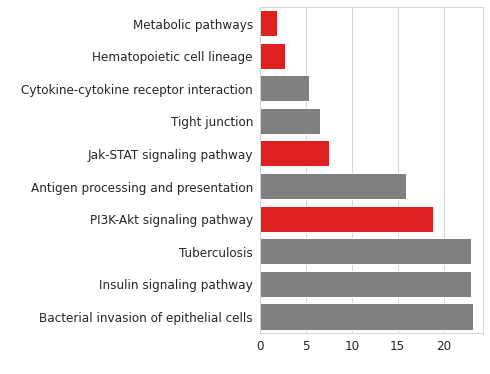

In [10]:
# plot top 10 pathways

import matplotlib
matplotlib.rc('ytick', labelsize=12)
matplotlib.rc('xtick', labelsize=12) 

## plot pathways sorted by average rank across different thresholds
top_5_frame = ranks_frame.mean(1).sort_values()[:10]
top_5_frame.columns = ['mean_rank']
top_5_frame_new = pd.DataFrame()
top_5_frame_new['term_description'] = top_5_frame.index
top_5_frame_new['avg_rank'] = top_5_frame.values

sb.set_style("whitegrid")
plt.figure(figsize=(4,6))
clrs = ['red','red','grey','grey','red','grey','red','grey','grey','grey']
sb.barplot(x='avg_rank',y='term_description',data=top_5_frame_new,palette=clrs)
plt.xlabel(' ')
plt.ylabel(' ')
# plt.savefig('ensemble_xgboost_pathways_fig.pdf')
plt.show()